In [ ]:
!unzip drive/MyDrive/dataset.zip

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# # Preparing dataset for Stratified Sampling.

# import shutil
# os.mkdir("data")
# os.mkdir("data/noninteracting")
# os.mkdir("data/merger")

# src_train_merger = "dataset_zurich/train/merger/"
# src_val_merger = "dataset_zurich/val/merger/"
# src_train_noninteracting = "dataset_zurich/train/noninteracting/"
# src_val_noninteracting = "dataset_zurich/val/noninteracting/"

# dest_merger = "data/merger/"
# dest_noninteracting = "data/noninteracting/"

# for filename in os.listdir(src_train_merger):
#   shutil.move(os.path.join(src_train_merger, filename), dest_merger)
# for filename in os.listdir(src_val_merger):
#   shutil.move(os.path.join(src_val_merger, filename), dest_merger)

# for filename in os.listdir(src_train_noninteracting):
#   shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
# for filename in os.listdir(src_val_noninteracting):
#   shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [ ]:
data_transforms = {
    "train": transforms.Compose([
        # transforms.RandomResizedCrop(225),
        # transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(250),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        # transforms.Resize(250),
        transforms.CenterCrop(250),
        # transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        # transforms.Resize(250),
        # transforms.CenterCrop(224),
        # transforms.Resize(200),
        transforms.CenterCrop(250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

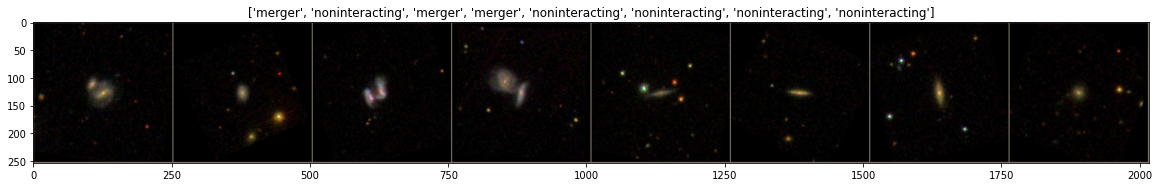

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 60))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class_names

['merger', 'noninteracting']

In [ ]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
model = model.to(device)

In [ ]:
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [ ]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 6  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            ### EARLY STOPPING ###
            if phase == "val" and epoch_loss < min_val_loss:
              epochs_no_improve = 0
              min_val_loss = epoch_loss
            elif phase == "val" and epoch_loss >= min_val_loss:
              epochs_no_improve += 1
            
            if epoch > 5 and (epochs_no_improve == n_epochs_stop):
              print("Early stopping!")
              return  # Way to come out of all nested loops
            
            ### end ###

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
trained_model = train_model(model, criterion, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 0/49
----------
train Loss: 0.5556 Acc: 0.7175
val Loss: 0.4957 Acc: 0.7854

Epoch 1/49
----------
train Loss: 0.4286 Acc: 0.8039
val Loss: 0.4057 Acc: 0.8280

Epoch 2/49
----------
train Loss: 0.3536 Acc: 0.8488
val Loss: 0.2846 Acc: 0.8875

Epoch 3/49
----------
train Loss: 0.2987 Acc: 0.8832
val Loss: 0.2880 Acc: 0.8875

Epoch 4/49
----------
train Loss: 0.2848 Acc: 0.8904
val Loss: 0.2634 Acc: 0.9017

Epoch 5/49
----------
train Loss: 0.2642 Acc: 0.8987
val Loss: 0.2443 Acc: 0.9070

Epoch 6/49
----------
train Loss: 0.2469 Acc: 0.9077
val Loss: 0.2288 Acc: 0.9087

Epoch 7/49
----------
train Loss: 0.2432 Acc: 0.9099
val Loss: 0.2287 Acc: 0.9170

Epoch 8/49
----------
train Loss: 0.2249 Acc: 0.9164
val Loss: 0.2244 Acc: 0.9212

Epoch 9/49
----------
train Loss: 0.2352 Acc: 0.9134
val Loss: 0.2248 Acc: 0.9190

Epoch 10/49
----------
train Loss: 0.2155 Acc: 0.9182
val Loss: 0.2097 Acc: 0.9200

Epoch 11/49
----------
train Loss: 0.2124 Acc: 0.9210
val Loss: 0.1993 Acc: 0.9307

Ep

In [ ]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 94.04702351175588


In [ ]:
preds_ = np.concatenate([pred.cpu().numpy() for pred in all_preds])

In [ ]:
preds_

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
targets_ = np.concatenate([target.cpu().numpy() for target in all_targets])

In [ ]:
from sklearn.metrics import  confusion_matrix, classification_report

In [ ]:
print(confusion_matrix(targets_, preds_))
print("\n")
print(classification_report(targets_, preds_))

[[1381  117]
 [ 121 2379]]


              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1498
           1       0.95      0.95      0.95      2500

    accuracy                           0.94      3998
   macro avg       0.94      0.94      0.94      3998
weighted avg       0.94      0.94      0.94      3998



In [ ]:
!pip install plot-metric

In [ ]:
from plot_metric.functions import BinaryClassification

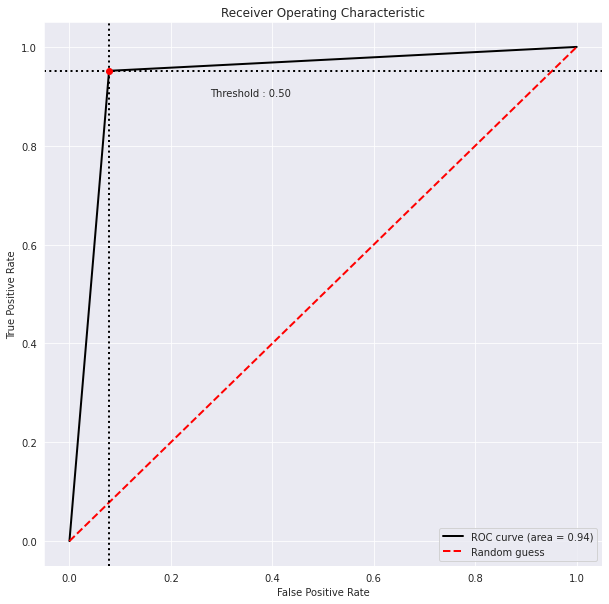

In [ ]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds_, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()